In [1]:
import os
import numpy as np
import rasterio
from rasterio import features
from spectral.io import envi
import matplotlib.pyplot as plt
import geopandas as gpd
from sklearn.ensemble import RandomForestClassifier
from scipy.ndimage import generic_filter
from scipy import stats
from rasterio.plot import reshape_as_image
from datetime import date
import glob
from skimage import exposure  # for brightness/contrast correction

In [89]:
from src import composite_analysis
import os
import numpy as np
import rasterio
from rasterio.plot import reshape_as_image

import matplotlib.pyplot as plt
import geopandas as gpd
from sklearn.ensemble import RandomForestClassifier
from skimage.morphology import remove_small_objects
from scipy.ndimage import label




### Train classifier on 2023 ROIs

In [126]:
roi_sources = {
    "Cloud": [("LC08_L2SP_109060_20230506_20230509_02_T1", "2023_x4_v2_SHPs/Cloud.shp")],
    "Jungle": [("LC08_L2SP_109060_20230506_20230509_02_T1", "2023_x4_v2_SHPs/Jungle.shp"),
              ("LC08_L2SP_109060_20160603_20200907_02_T1", "2016_x2_SHPs/Burnt_Jungle.shp")],
    "Mining": [("LC08_L2SP_109060_20230506_20230509_02_T1", "2023_x4_v2_SHPs/Mining.shp")],
    "Water": [("LC08_L2SP_109060_20230506_20230509_02_T1", "2023_x4_v2_SHPs/Water.shp"),
        ("LC08_L2SP_109060_20190204_20200829_02_T1", "2019_x1_SHPs/Ocean.shp"),
        ("LC08_L2SP_109060_20160603_20200907_02_T1", "2016_x2_SHPs/Ocean.shp")
    ],
    #"Burnt": [("stacked/2016", "ROIs/2016_x2_SHPs/Burnt_Forest.shp") ]
}


roi_folder_path = "data/training_rois/"

img_folder_path = "data/stacked/"

root = '.'

classified_folder_path = 'output/classified/'

In [157]:
img_name = "LC09_L2SP_109060_20250722_20250725_02_T1"

def get_cloud_mask_from_stacked(img_name, img_folder_path = "data/stacked/"):
    with rasterio.open(img_folder_path + img_name + "/" + img_name) as src:
        img_data = src.read()

    qa = img_data[-1]
    nodata = src.nodata

    cloud_shadow=True

    cirrus=False

    cloud_mask = (
        (
            (qa & composite_analysis.QA_BITS['cloud'])
            | (qa & composite_analysis.QA_BITS['cloud_shadow'] & cloud_shadow)
            | (qa & composite_analysis.QA_BITS['cirrus'] & cirrus)
        ) > 0
    )

    if nodata is not None:
        cloud_mask[qa == nodata] = True  # treat nodata as "ignore"

    return cloud_mask




 

In [147]:
# -------------------------------
# 1. Function to extract pixels from shapefile + image
# -------------------------------
def extract_pixels_from_roi(img_name, 
                            roi_name, 
                            roi_folder_path = "data/training_rois/",
                            img_folder_path = "data/stacked/",
                            cloud_masking = True
                            ):
    """Extract pixels inside ROI polygons for a given image and shapefile."""
    with rasterio.open(img_folder_path + img_name + "/" + img_name) as src:
        img_data = src.read()
        transform = src.transform
        

    roi_gdf = gpd.read_file(roi_folder_path + roi_name)
    mask = rasterio.features.geometry_mask(
        roi_gdf.geometry,
        out_shape=(img_data.shape[1], img_data.shape[2]),
        transform=transform,
        invert=True
    )
    
    cloud_mask = get_cloud_mask_from_stacked(img_name, img_folder_path)

    ys, xs = np.where(mask & ~(cloud_mask & cloud_masking) )
    pixels = img_data[:, ys, xs].T
    return pixels

def extract_and_train(
    roi_sources, 
    roi_folder_path = roi_folder_path,
    img_folder_path = img_folder_path,
    cloud_masking = True
):
    """ Extracts all classes from given ROI dict, and trains classifier. """
    classes = list(roi_sources.keys())

    X_list, y_list = [], []

    for class_id, class_name in enumerate(classes):
        for img_path, shp_path in roi_sources[class_name]:
            pixels = extract_pixels_from_roi(img_path, shp_path, 
                                             roi_folder_path, img_folder_path,
                                             cloud_masking)
            X_list.append(pixels)
            y_list.append(np.full(len(pixels), class_id))

    # -------------------------------
    # Stack into training arrays             
    # -------------------------------
    X_train = np.vstack(X_list)
    y_train = np.concatenate(y_list)

    # -------------------------------
    # Train classifier
    # -------------------------------
    clf = RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=0)
    clf.fit(X_train, y_train)

    return clf


In [ ]:
clf = extract_and_train(roi_sources, cloud_masking = True)

### Classify each image 2013-2023

In [149]:
def clean_small_regions(arr, min_size=50, connectivity=2):
    """
    Removes connected regions smaller than `min_size` for each unique value in arr.
    
    Parameters
    ----------
    arr : 2D numpy array (numeric labels, e.g. -1..3)
    min_size : int
        Minimum region size (in pixels) to keep.
    connectivity : int
        1 for 4-connectivity, 2 for 8-connectivity.
    """
    out = np.copy(arr)
    for val in np.unique(arr):
        mask = arr == val
        labeled, n = label(mask, structure=np.ones((3,3)) if connectivity == 2 else None)
        if n == 0:
            continue
        counts = np.bincount(labeled.ravel())
        remove_mask = np.isin(labeled, np.where(counts < min_size)[0])
        out[remove_mask] = np.median(arr)  # or another fill value, e.g. np.nan
    return out

def classify_img(clf,
              img_name, 
              img_folder_path = img_folder_path,
              classified_folder_path = classified_folder_path,
              plot = False,
              cloud_masking = True):
    """ Apply trained classifier to specified image"""

    # -------------------------------
    # 1. Open image
    # -------------------------------

    img_path = img_folder_path + img_name + "/" + img_name
    with rasterio.open(img_path) as src:
        img = src.read()
        profile = src.profile
        rgb = reshape_as_image(img)[:, :, :3]  # for display
        transform = src.transform
    
    # -------------------------------
    # 2. Classify image
    # -------------------------------
    h, w = img.shape[1], img.shape[2]
    X = img.reshape(img.shape[0], -1).T
    y_pred = clf.predict(X)
    classified = y_pred.reshape(h, w)
    
    # -------------------------------
    # 3. Mask cloud
    # ------------------------------- 

    cloud_mask = get_cloud_mask_from_stacked(img_name, img_folder_path)

    if cloud_masking:
        classified[cloud_mask] = 0

    if plot:    
        plt.figure(figsize=(8, 6))
        plt.imshow(classified, cmap="tab20")
        plt.title("Raw classification")
        plt.axis("off")
        plt.show()

    # -------------------------------
    # 4. Smooth result
    # ------------------------------- 
    smoothed = clean_small_regions(classified)
    
    if plot:
        plt.figure(figsize=(8, 6))
        plt.imshow(smoothed, cmap="tab20")
        plt.title("Smoothed classification")
        plt.axis("off")
        plt.show()
    
    # -------------------------------
    # 4. Save smoothed result
    # -------------------------------
    out_path = classified_folder_path + img_name + "_classified.tif"
    with rasterio.open(out_path, "w", **profile) as dst:
        dst.write(smoothed.astype(np.uint8), 1)

    return smoothed

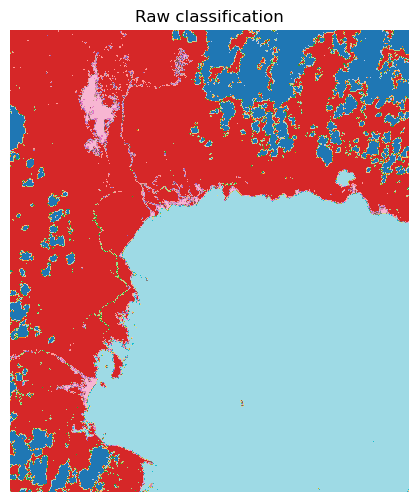

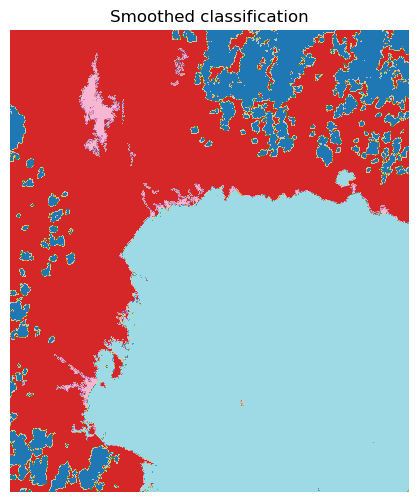

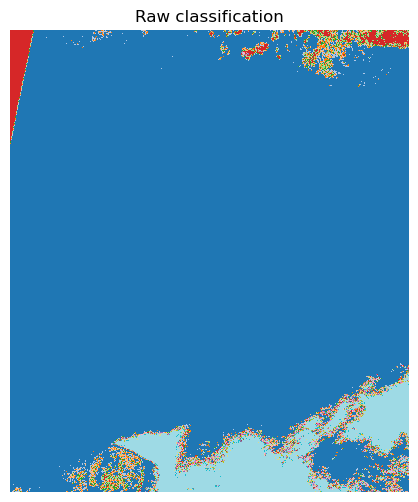

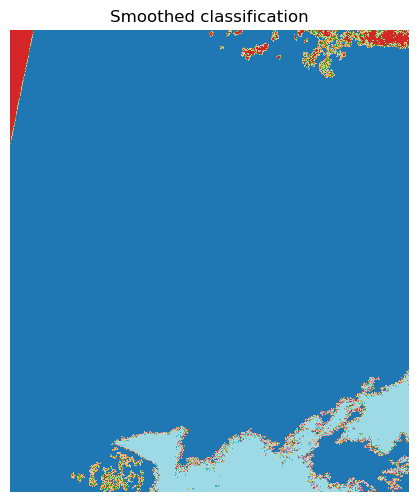

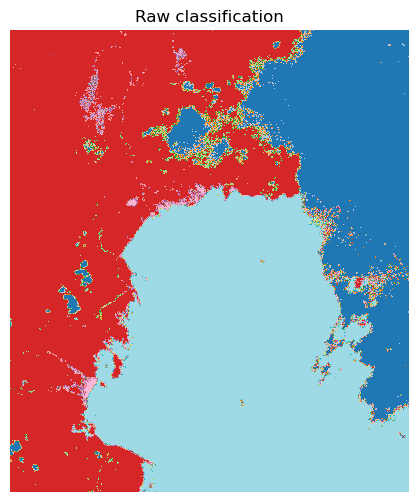

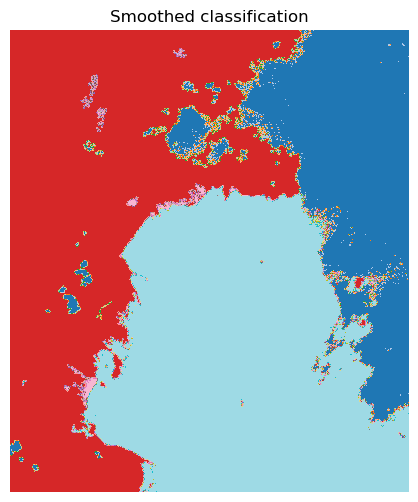

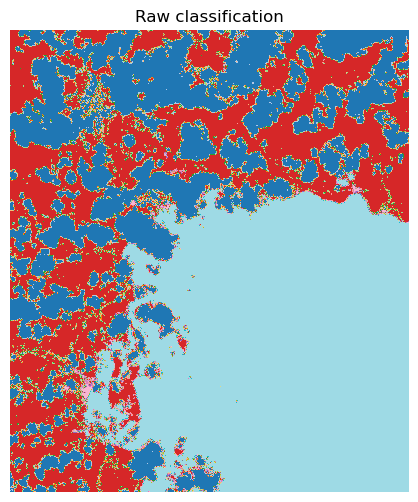

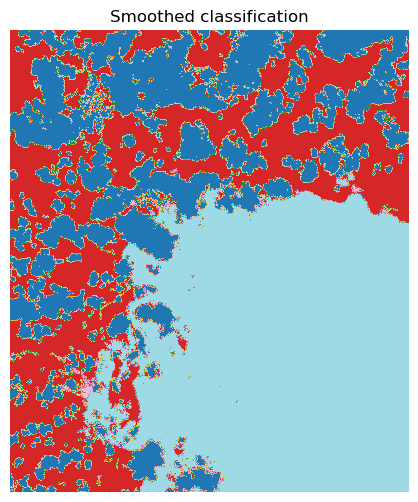

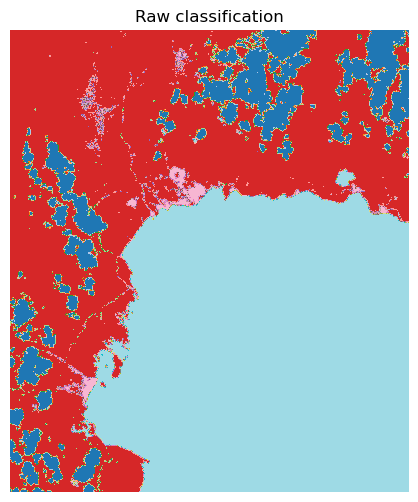

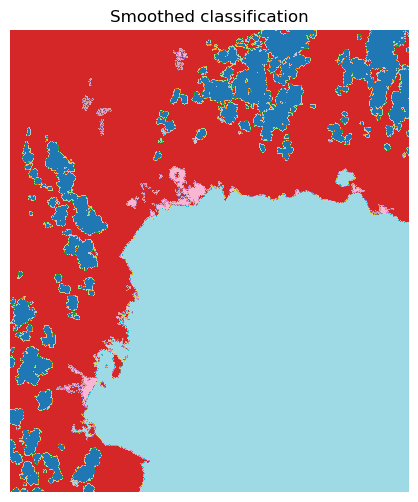

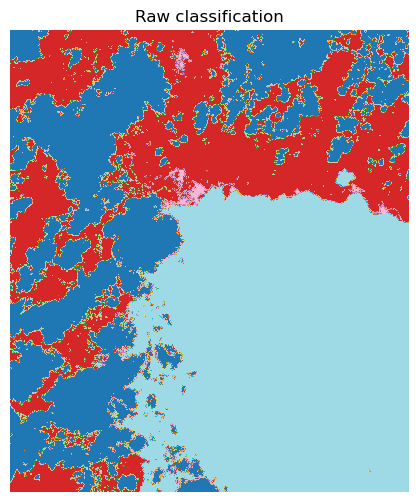

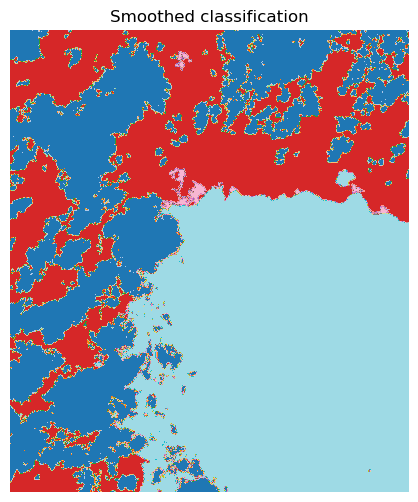

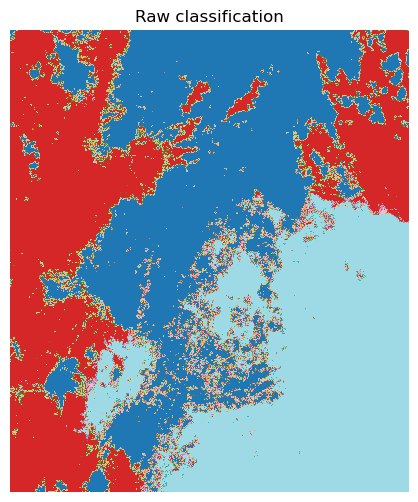

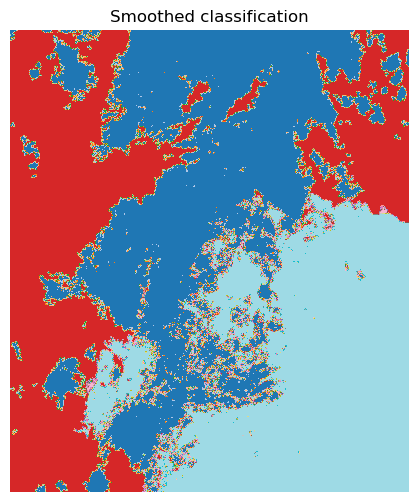

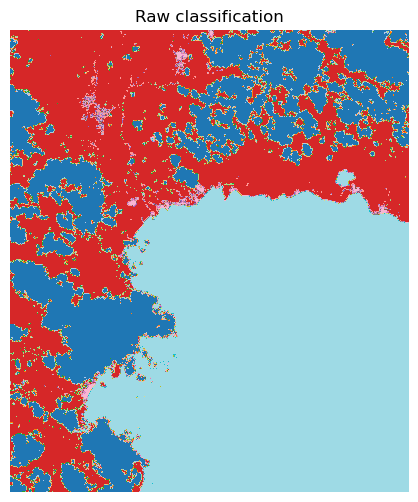

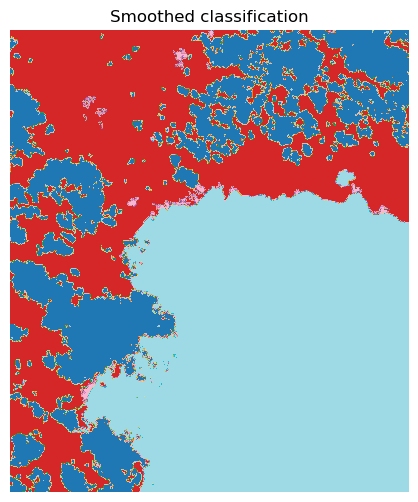

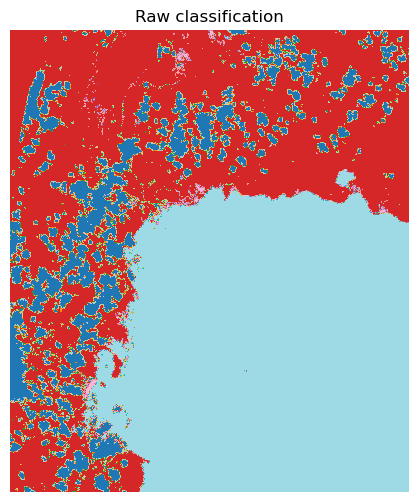

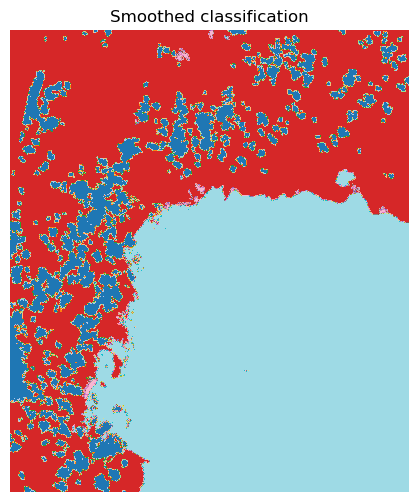

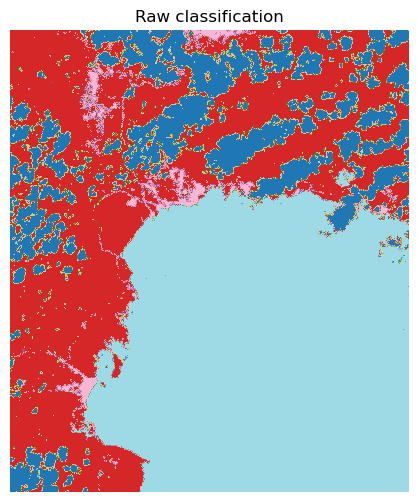

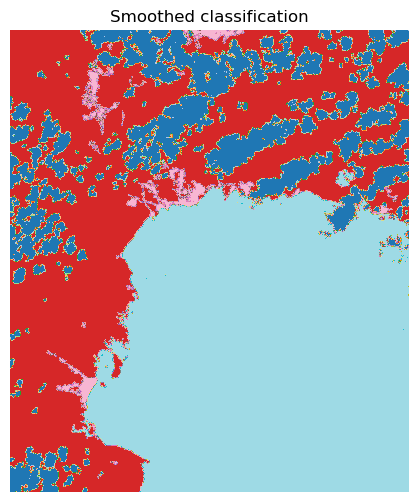

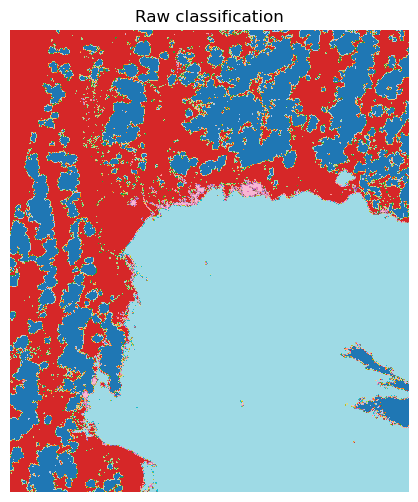

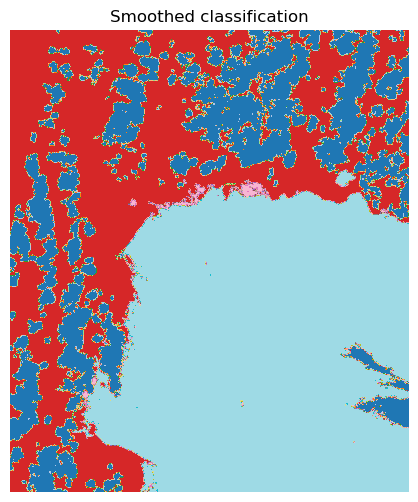

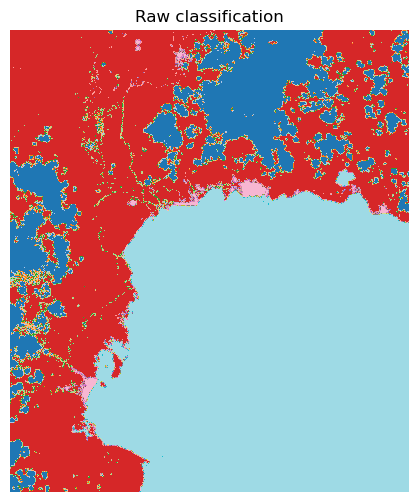

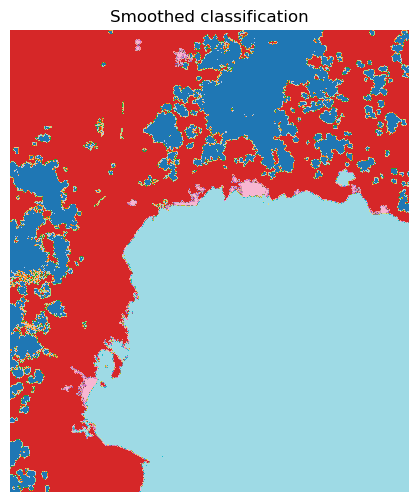

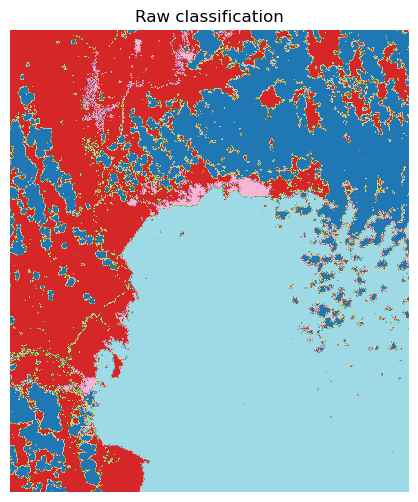

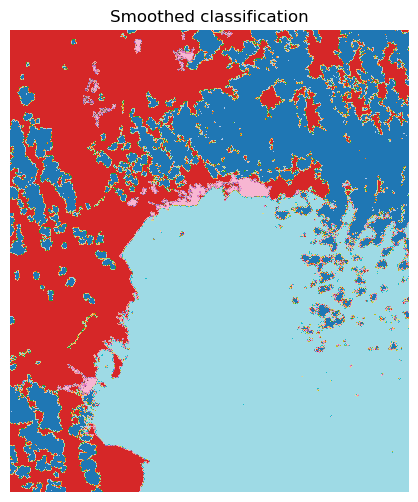

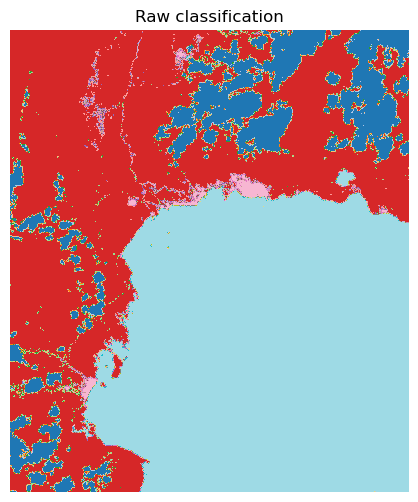

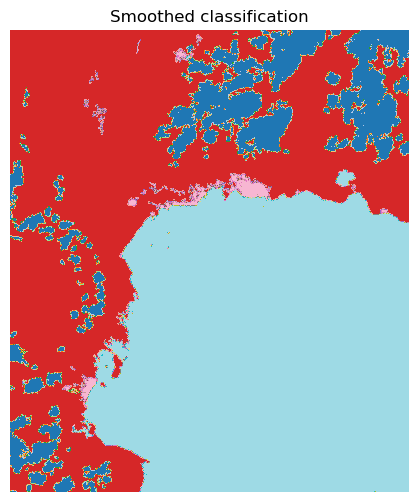

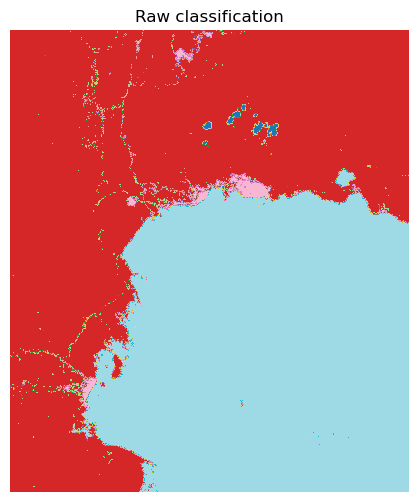

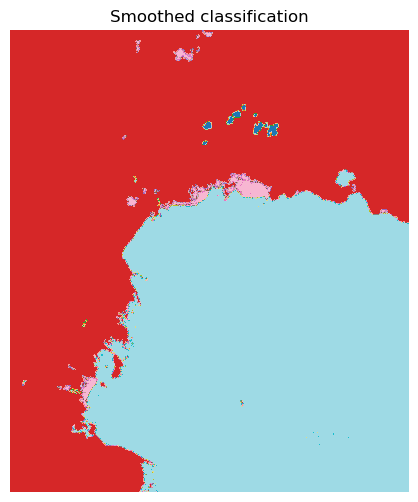

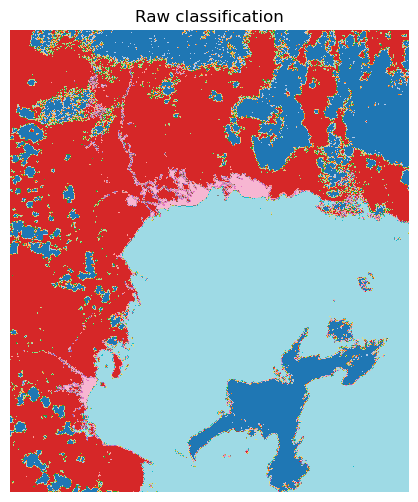

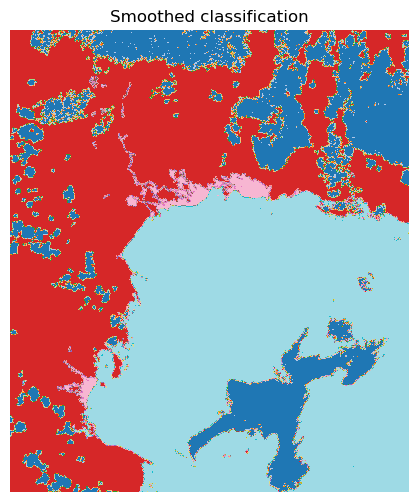

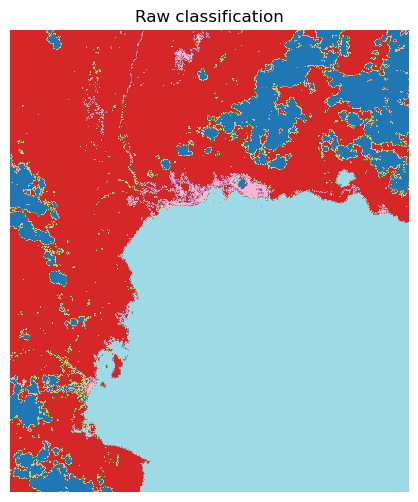

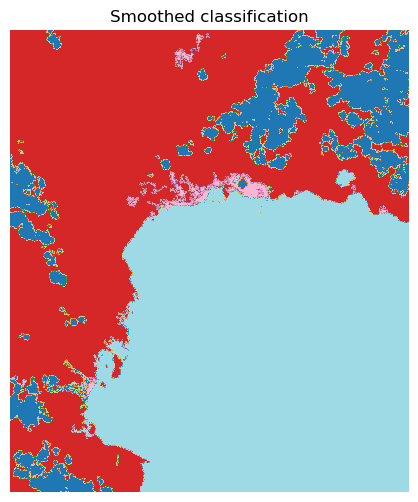

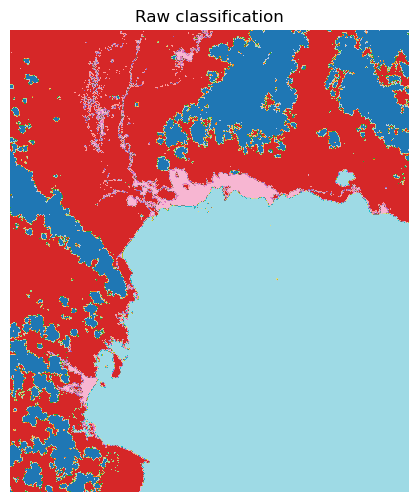

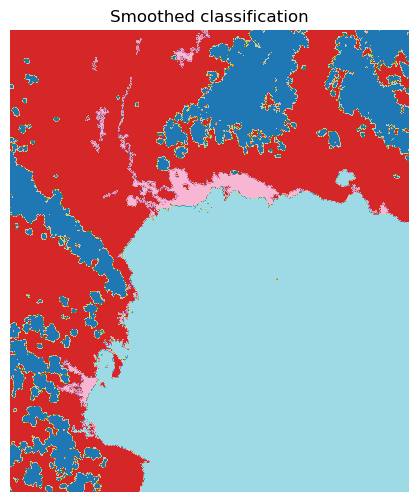

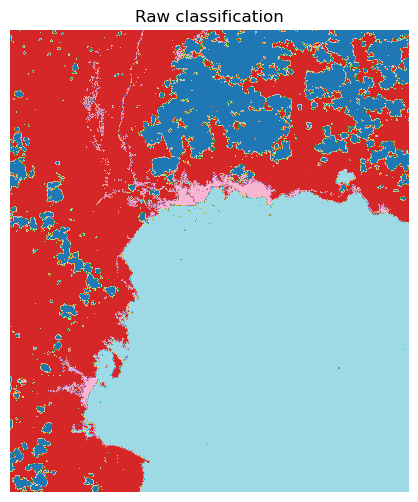

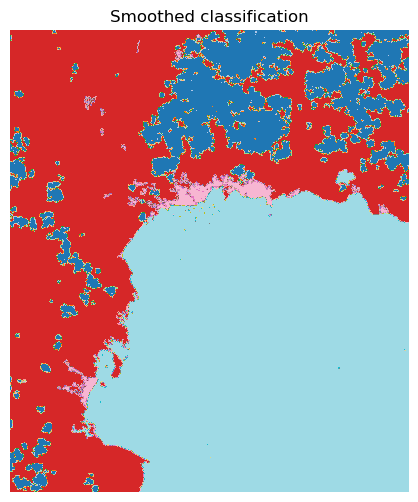

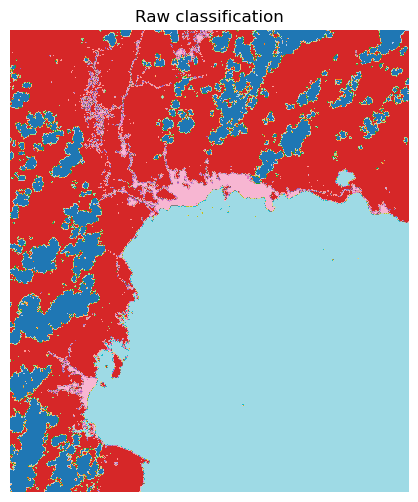

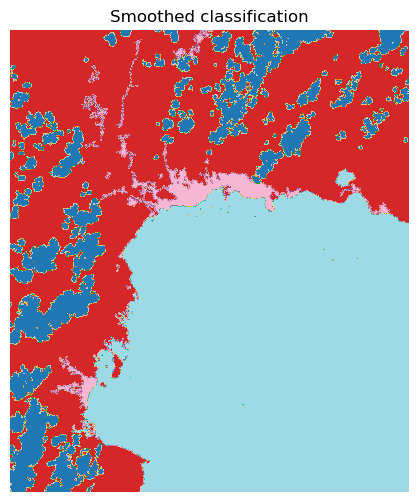

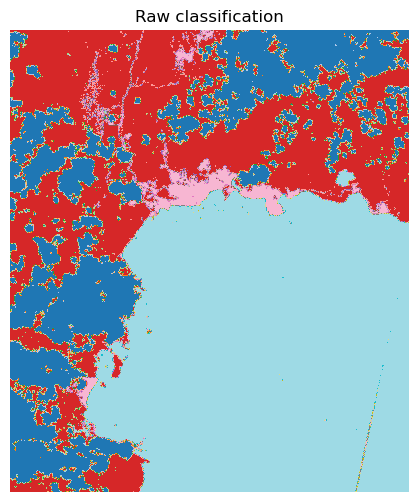

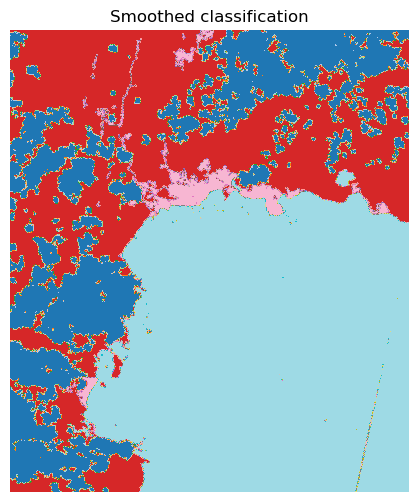

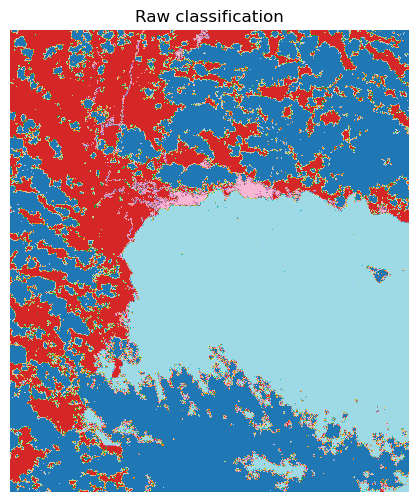

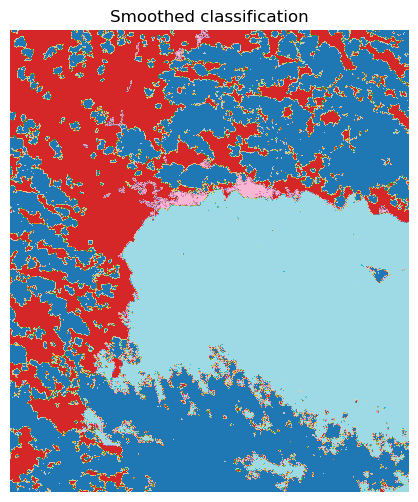

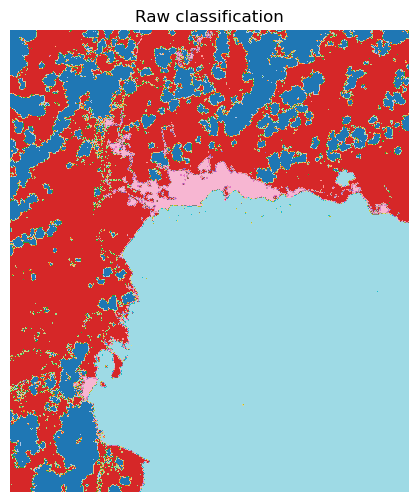

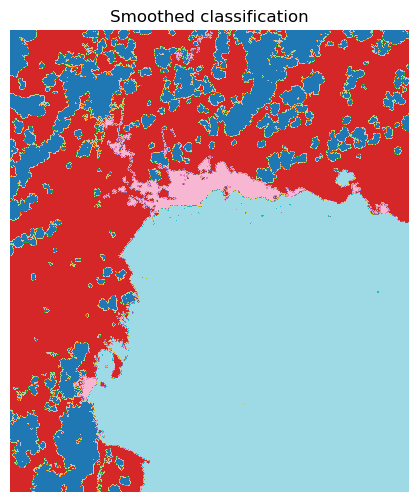

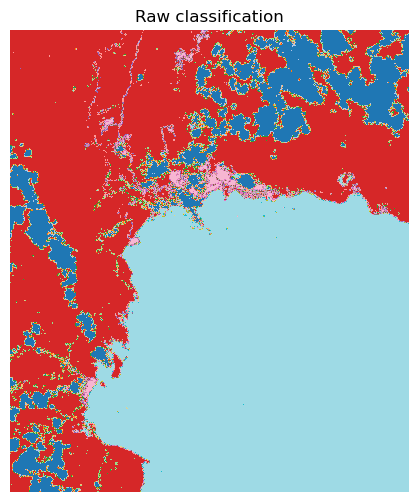

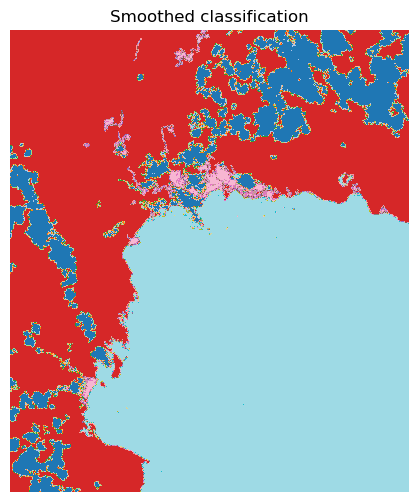

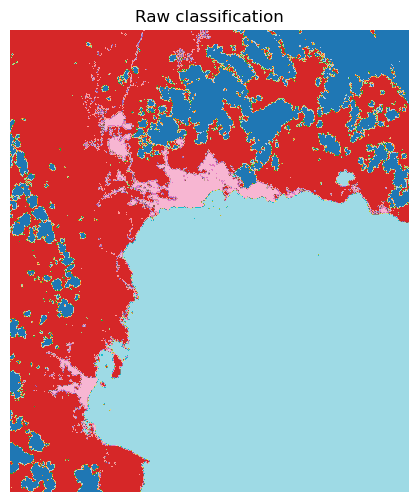

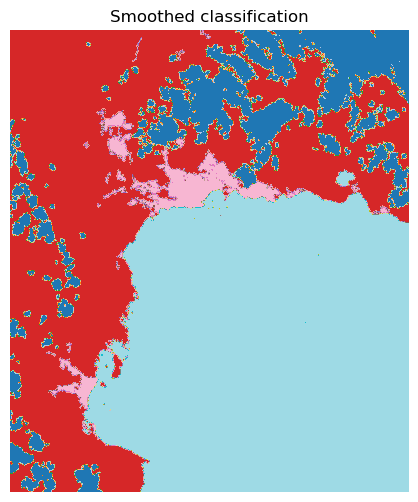

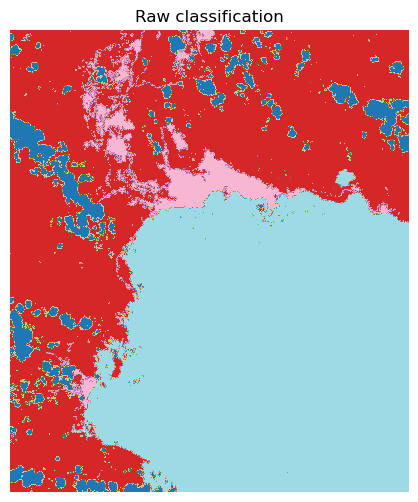

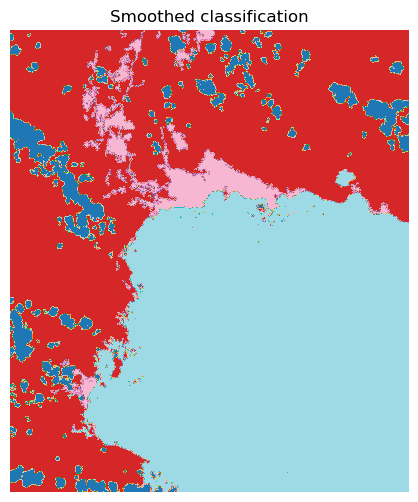

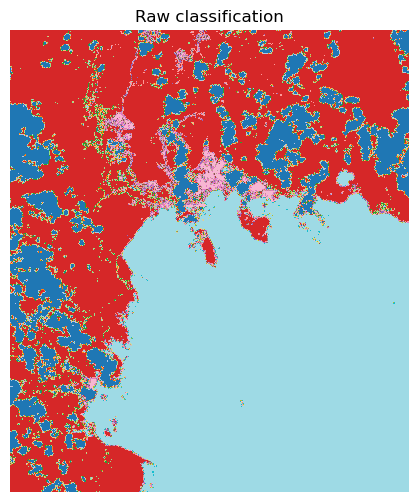

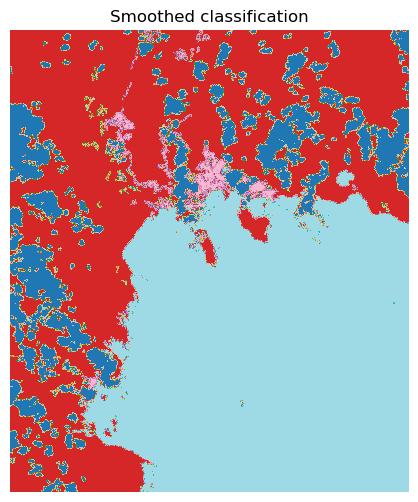

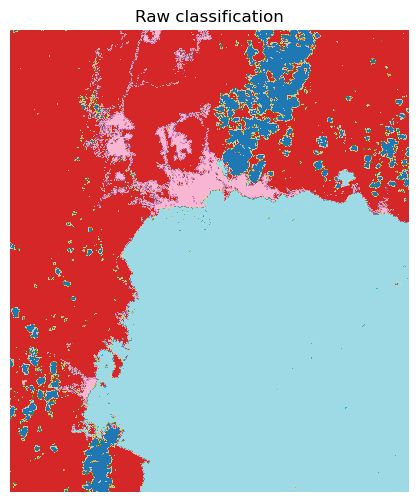

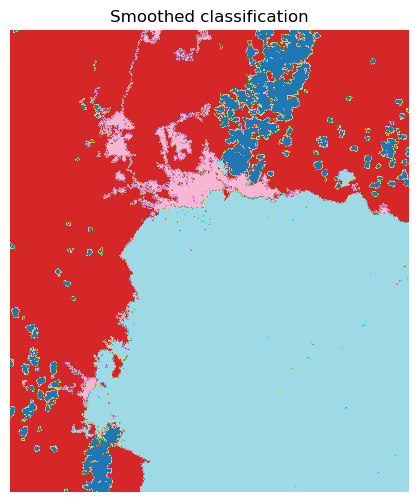

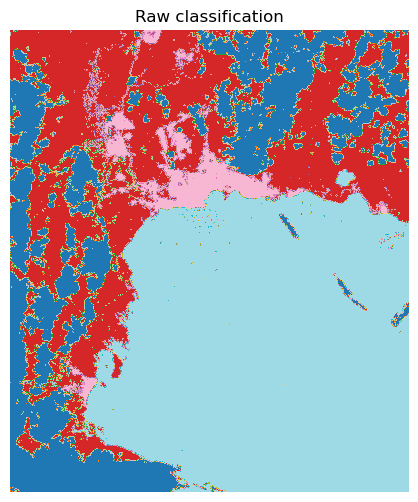

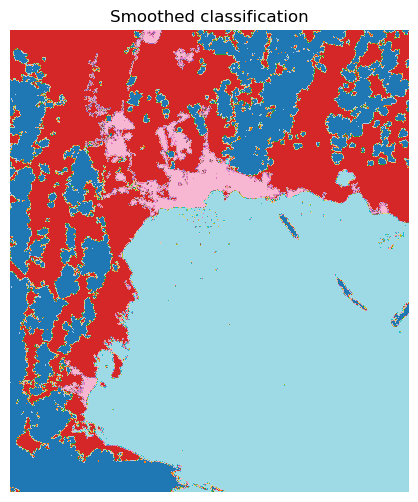

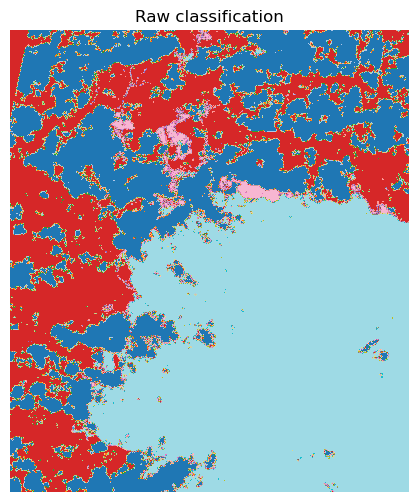

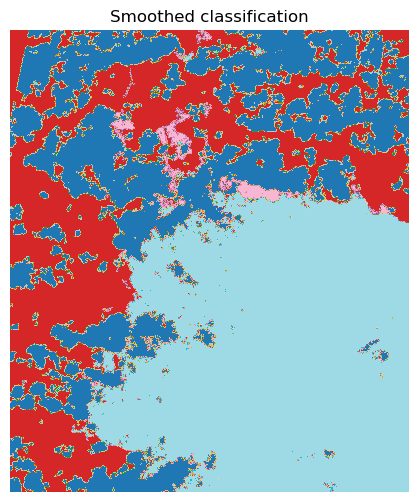

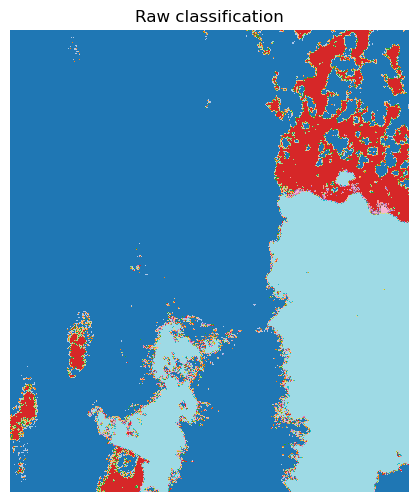

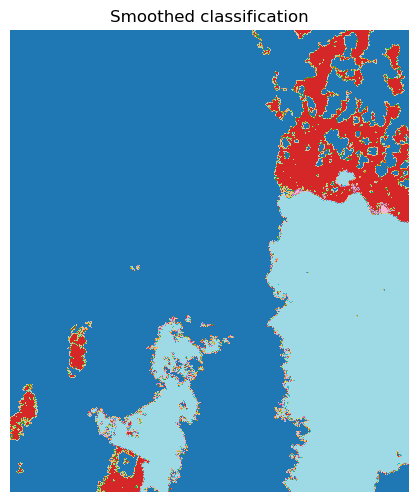

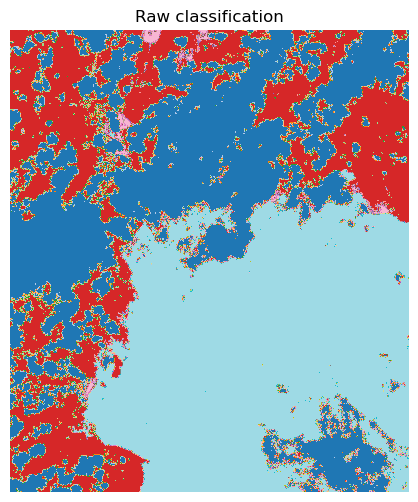

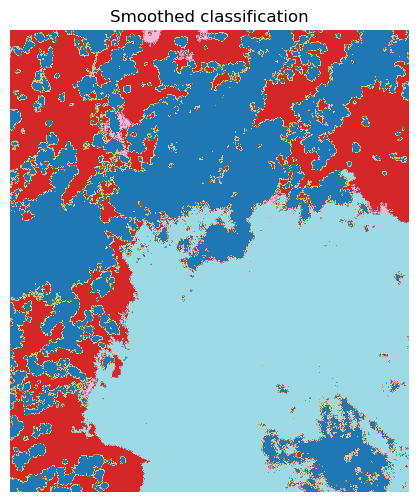

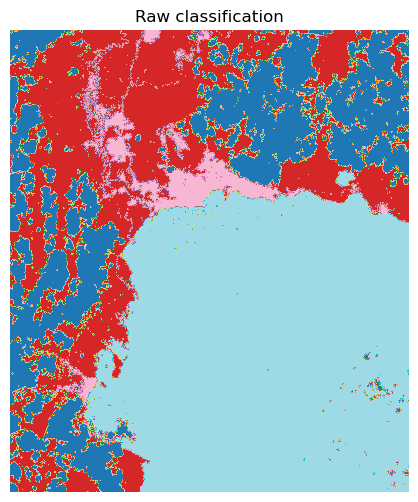

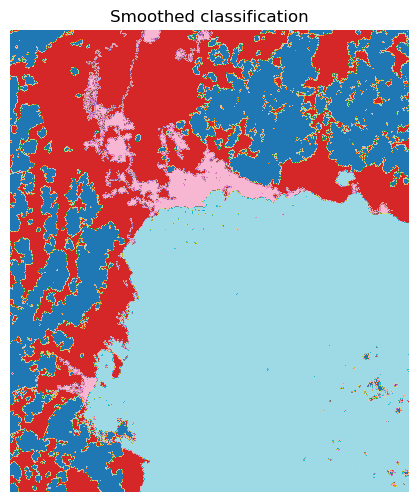

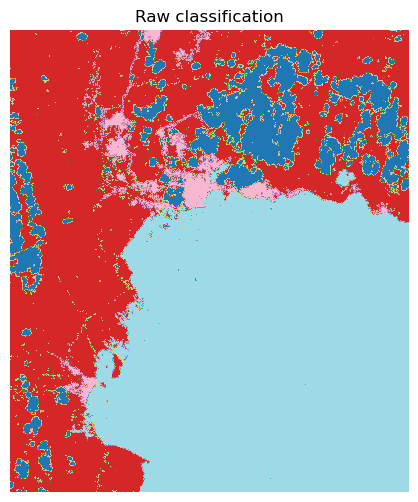

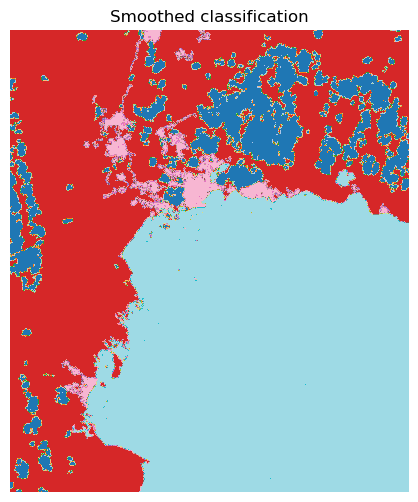

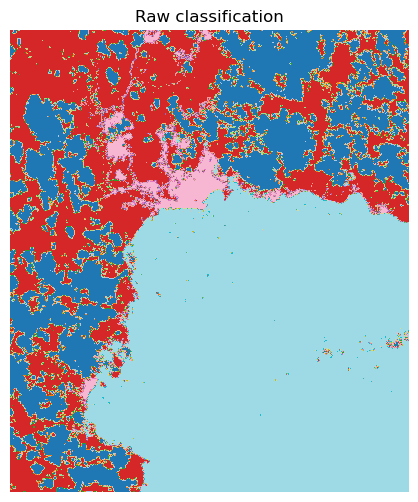

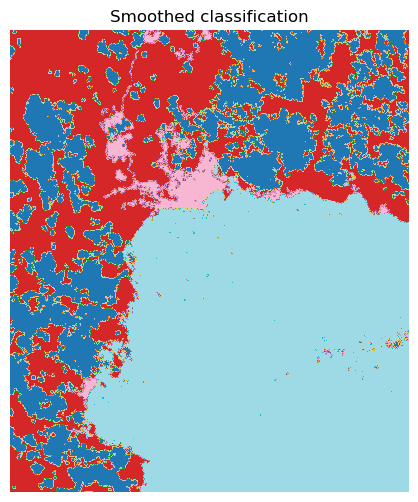

In [159]:
for img_name in os.listdir(img_folder_path):
    classify_img(clf,img_name, plot = True, cloud_masking = True)

In [152]:
img_name = 'LC08_L2SP_109060_20230506_20230509_02_T1'

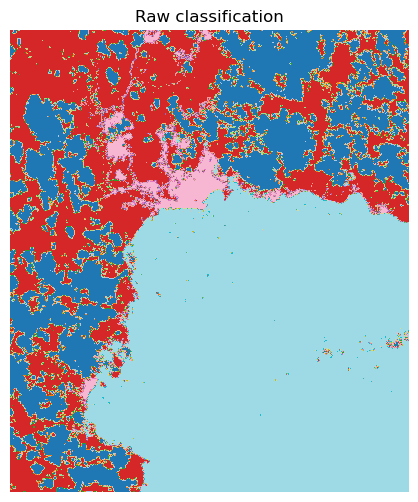

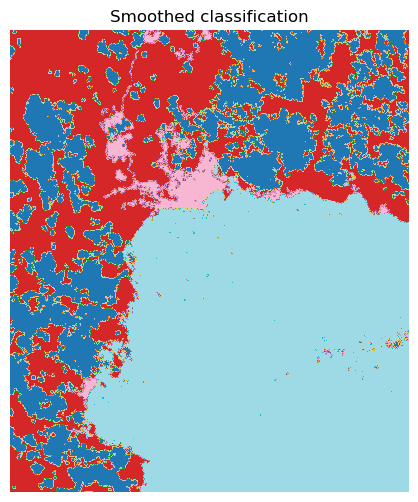

In [156]:
clf = extract_and_train(roi_sources, cloud_masking = True)
smoothed = classify_img(clf,img_name, plot = True, cloud_masking = True)

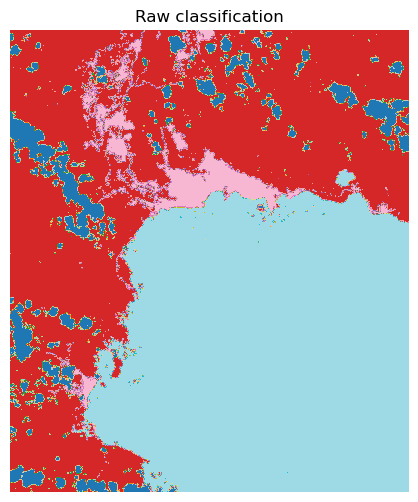

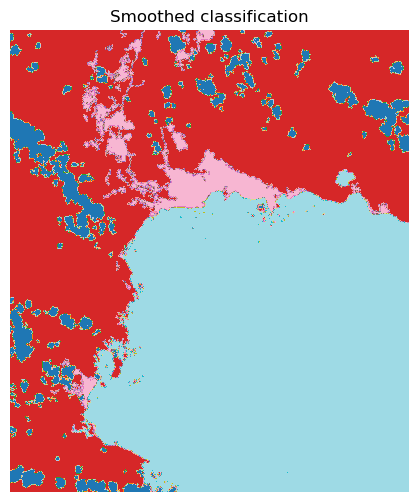

In [ ]:
clf = extract_and_train(roi_sources, cloud_masking = False)
smoothed = classify_img(clf,img_name, plot = True, cloud_masking = False)

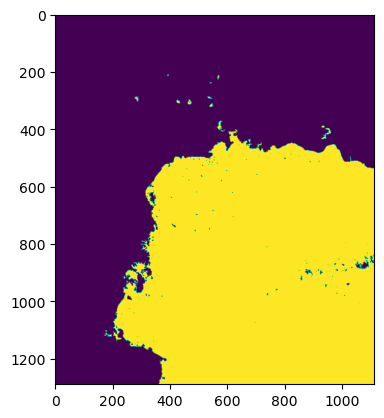

In [135]:
plt.imshow(smoothed == 3)

In [107]:
np.unique(smoothed, return_counts=True)

(array([-2,  0,  1,  2,  3]),
 array([249349,  73993, 423789,  39684, 648955], dtype=int64))

In [6]:
if False:
    class_img("2013")

In [7]:
if False:
    class_img("2016")
    class_img("2017")
    class_img("2019")
    class_img("2020")
    class_img("2021")
    class_img("2022")
    class_img("2023")

### Map classification images

Found years: [2013, 2016, 2017, 2019, 2020, 2021, 2022, 2023]
Stack shape: (8, 1290, 1113)


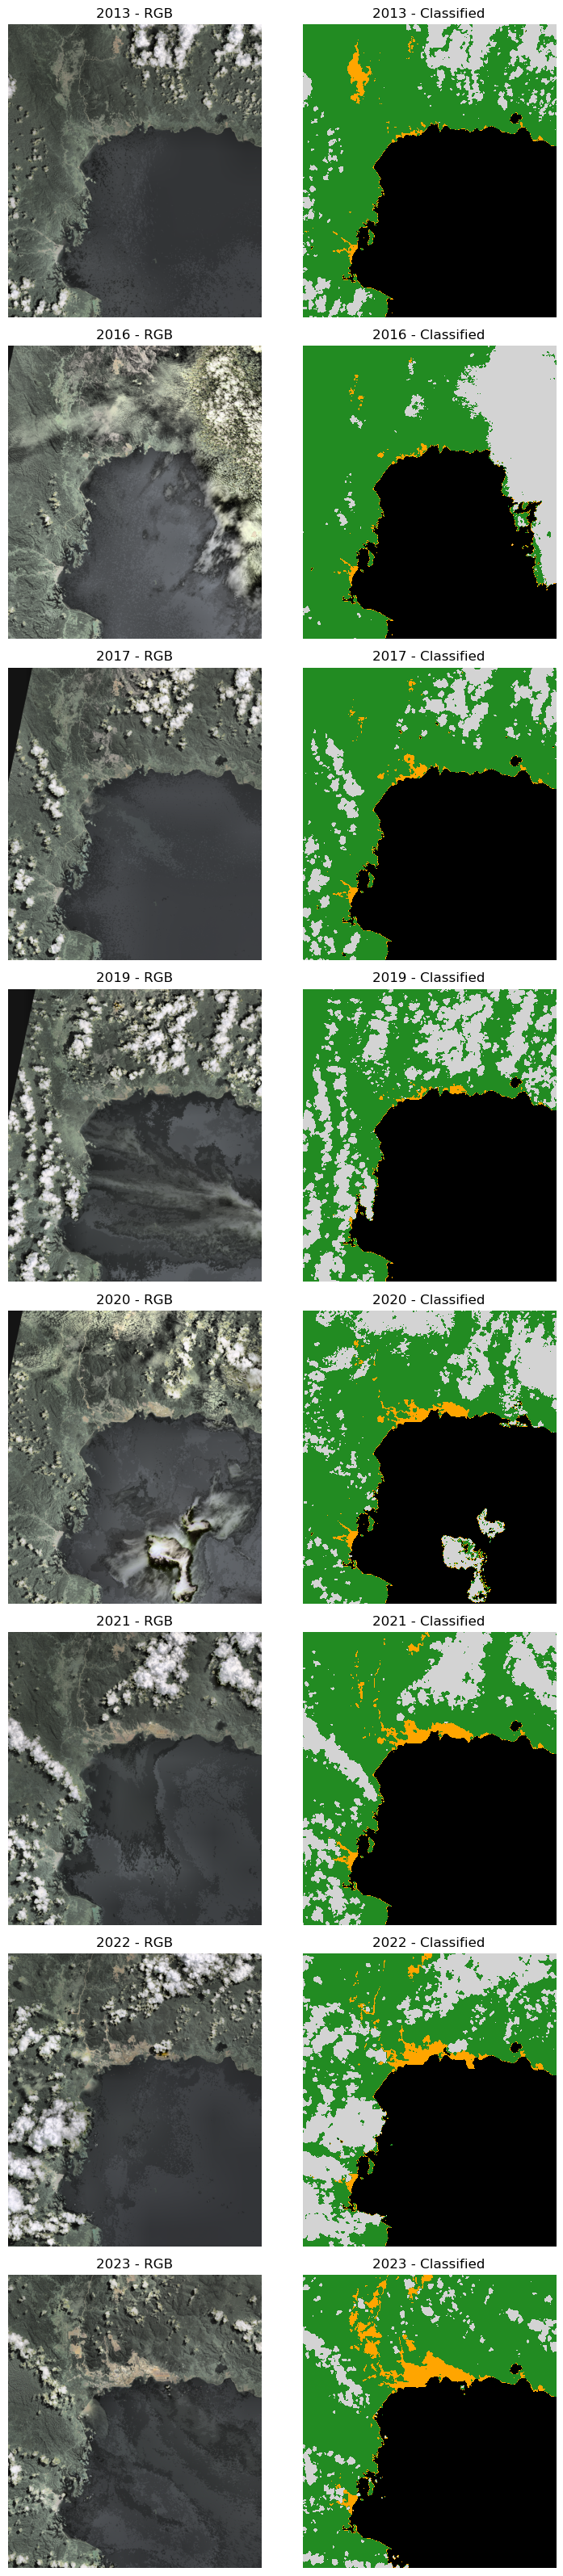

In [9]:

# ---------------------------------
# 1. Input setup
# ---------------------------------
data_dir = ""
files = sorted(glob.glob(os.path.join(data_dir, "python_classified/classified_*_smooth_v2.tif")))
years = [int(os.path.basename(f).split("_")[1]) for f in files]
print("Found years:", years)

# ---------------------------------
# 2. Read and stack rasters (classifications)
# ---------------------------------
stack = []
meta = None
for f in files:
    with rasterio.open(f) as src:
        data = src.read(1)
        stack.append(data)
        if meta is None:
            meta = src.meta

stack = np.stack(stack, axis=0)  # shape: (time, H, W)
H, W = stack.shape[1:]
print("Stack shape:", stack.shape)

# ---------------------------------
# 3. Plot each year: image + classification
# ---------------------------------
# Define your class colors
classes = {
    3: ("Ocean", "deepskyblue"),
    0: ("Cloud", "lightgrey"),
    1: ("Jungle", "forestgreen"),
    2: ("Mining", "orange"),
    -1: ("No data", "black")
}
cmap = plt.matplotlib.colors.ListedColormap([v[1] for v in classes.values()])
bounds = list(classes.keys())

n_years = len(years)
fig, axes = plt.subplots(n_years, 2, figsize=(8, 4 * n_years))

for i, year in enumerate(years):
    # Load the corresponding original stacked image
    img_path = f"Stacked/{year}"
    with rasterio.open(img_path) as src:
        img = src.read([4, 3, 2])  # RGB bands (assumed first 3)
        rgb = reshape_as_image(img.astype(float))
    
    # ---------------------------------
    # 3a. Brightness/contrast correction
    # ---------------------------------
    # Stretch intensity to 2–98% range to normalize contrast
    rgb_corrected = exposure.rescale_intensity(rgb, in_range='image', out_range=(0, 1))
    rgb_corrected = exposure.equalize_adapthist(rgb_corrected, clip_limit=0.06)  # optional adaptive contrast

    # Increase middle exposure
    rgb_corrected = exposure.adjust_gamma(rgb_corrected, gamma=0.9)

    #rgb_corrected = rgb
    # ---------------------------------
    # 3b. Get classification map
    # ---------------------------------
    cls = stack[i]

    # ---------------------------------
    # 3c. Plot side by side
    # ---------------------------------
    ax_img, ax_cls = axes[i] if n_years > 1 else (axes[0], axes[1])

    ax_img.imshow(rgb_corrected)
    ax_img.set_title(f"{year} - RGB")
    ax_img.axis("off")

    im = ax_cls.imshow(cls, cmap=cmap, vmin=min(bounds), vmax=max(bounds))
    ax_cls.set_title(f"{year} - Classified")
    ax_cls.axis("off")

plt.tight_layout()
plt.show()


### Calculate initial and final states, and year of transition

In [15]:

# ---------------------------------
# 3. Compute initial, final, and change years
# ---------------------------------
initial_state = np.full((H, W), -1, dtype=np.int16)
final_state = np.full((H, W), -1, dtype=np.int16)
change_year = np.full((H, W), -1, dtype=np.int16)

years = np.arange(2016, 2024)

for y in range(H):
    pix_seq = stack[:, y, :]
    ocean_mask = np.any(pix_seq == 3, axis=0)
    for x in range(W):
        if ocean_mask[x]:
            continue

        seq = pix_seq[:, x]
        noncloud_idx = np.where(seq != 0)[0]
        if len(noncloud_idx) == 0:
            continue

        first_i = noncloud_idx[0]
        last_i = noncloud_idx[-1]
        initial = seq[first_i]
        final = seq[last_i]

        initial_state[y, x] = initial
        final_state[y, x] = final

        if ((initial != 1) | (final != 2)):  # only track jungle origins
            continue
            
        jungle_array = np.where(seq == 2)[0]

        if len(jungle_array) == 0:
            continue

        change_year[y, x] = years[jungle_array[0]]

        continue 

        #below code is redundant, as long as above code works
        
        jungle_to_mine = np.where((seq[:-1] == 1) & (seq[1:] == 2))[0]
        if len(jungle_to_mine) == 0:
            continue

        change_i = jungle_to_mine[0] + 1
        #reverted = np.any(seq[change_i:] == 1) #instead of checking if it has reverted back to mining, add check above for final = mining (2) 
        #if not reverted:
        change_year[y, x] = years[change_i]

# ---------------------------------
# 4. Save 3-band output
# ---------------------------------
out_meta = meta.copy()
out_meta.update(dtype=rasterio.int16, count=3)

out_path = os.path.join(data_dir, "jungle_to_mine_change_v2.tif")
with rasterio.open(out_path, "w", **out_meta) as dst:
    dst.write(initial_state, 1)
    dst.write(final_state, 2)
    dst.write(change_year, 3)

print("✅ Saved:", out_path)


✅ Saved: jungle_to_mine_change_v2.tif


### Plot changes

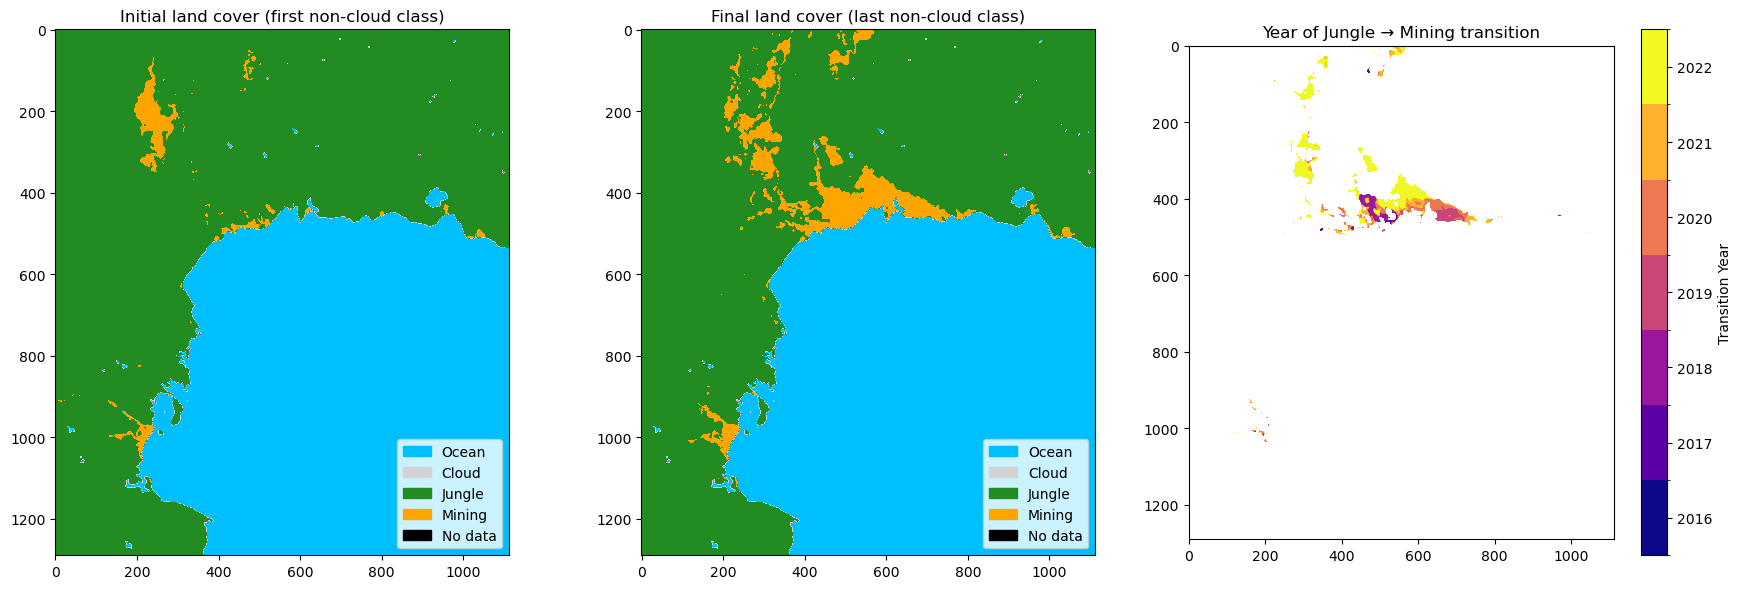

In [17]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.patches import Patch

# -------------------------------
# 1. Load raster
# -------------------------------
path = "jungle_to_mine_change_v2.tif"

with rasterio.open(path) as src:
    initial_state = src.read(1)
    final_state = src.read(2)
    change_year = src.read(3)

# -------------------------------
# 2. Class colors and labels
# -------------------------------
classes = {
    3: ("Ocean", "deepskyblue"),
    0: ("Cloud", "lightgrey"),
    1: ("Jungle", "forestgreen"),
    2: ("Mining", "orange"),
    -1: ("No data", "black")
}

vals = np.array(list(classes.keys()))
colors = [v[1] for v in classes.values()]
labels = [v[0] for v in classes.values()]

cmap_cat = ListedColormap(colors)
norm_cat = BoundaryNorm(np.arange(-1.5, 4.5, 1), cmap_cat.N)
legend_patches = [Patch(color=c, label=l) for c, l in zip(colors, labels)]

# -------------------------------
# 3. Change-year color setup
# -------------------------------
masked_years = np.where((change_year >= 2016) & (change_year <= 2023), change_year, np.nan)
years = np.arange(2016, 2024)
cmap_year = plt.cm.plasma
norm_year = BoundaryNorm(years - 0.5, cmap_year.N)

# -------------------------------
# 4. Plot
# -------------------------------
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# --- Initial state
im1 = axes[0].imshow(initial_state, cmap=cmap_cat, norm=norm_cat)
axes[0].set_title("Initial land cover (first non-cloud class)")
axes[0].legend(handles=legend_patches, loc="lower right", frameon=True)

# --- Final state
im2 = axes[1].imshow(final_state, cmap=cmap_cat, norm=norm_cat)
axes[1].set_title("Final land cover (last non-cloud class)")
axes[1].legend(handles=legend_patches, loc="lower right", frameon=True)

# --- Jungle→Mining year
im3 = axes[2].imshow(masked_years, cmap=cmap_year, norm=norm_year)
axes[2].set_title("Year of Jungle → Mining transition")
cbar = plt.colorbar(im3, ax=axes[2], boundaries=years - 0.5, ticks=years)
cbar.set_label("Transition Year")

plt.tight_layout()
plt.show()


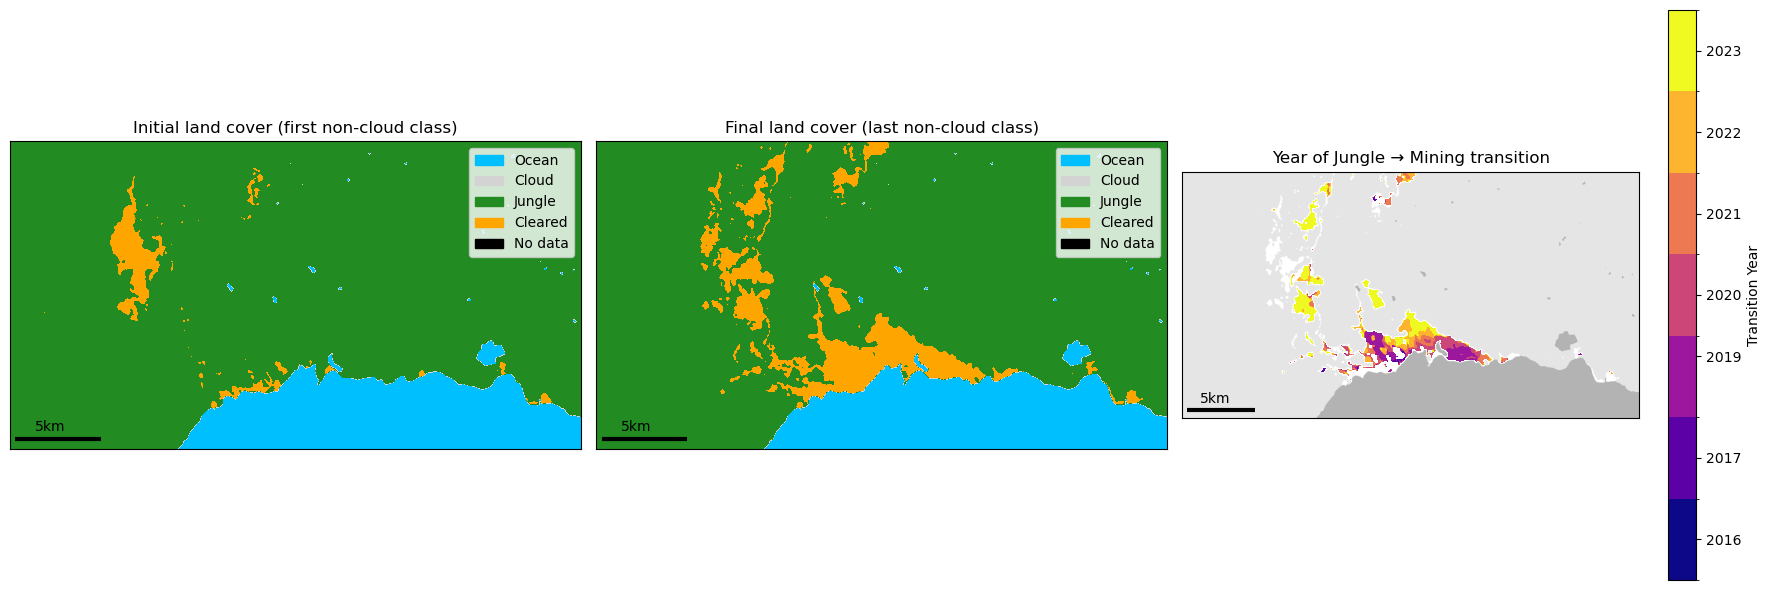

In [19]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.patches import Patch

# -------------------------------
# 1. Load raster (clip first 600 rows)
# -------------------------------
path = "jungle_to_mine_change_v2.tif"

with rasterio.open(path) as src:
    initial_state = src.read(1)[:600, :]
    final_state = src.read(2)[:600, :]
    change_year = src.read(3)[:600, :]

# -------------------------------
# 2. Class colors and labels
# -------------------------------
classes = {
    3: ("Ocean", "deepskyblue"),
    0: ("Cloud", "lightgrey"),
    1: ("Jungle", "forestgreen"),
    2: ("Cleared", "orange"),
    -1: ("No data", "black")
}

vals = np.array(list(classes.keys()))
colors = [v[1] for v in classes.values()]
labels = [v[0] for v in classes.values()]

cmap_cat = ListedColormap(colors)
norm_cat = BoundaryNorm(np.arange(-1.5, 4.5, 1), cmap_cat.N)
legend_patches = [Patch(color=c, label=l) for c, l in zip(colors, labels)]

# -------------------------------
# 3. Change-year color setup
# -------------------------------
masked_years = np.where((change_year >= 2016) & (change_year <= 2023), change_year, np.nan)

# Define only the years you want
years = np.array([2016, 2017, 2019, 2020, 2021, 2022, 2023])

# Create discrete colormap and normalization
cmap_year = plt.cm.plasma(np.linspace(0, 1, len(years)))
cmap_year = ListedColormap(cmap_year)
boundaries = np.concatenate(([years[0] - 0.5], years + 0.5))
norm_year = BoundaryNorm(boundaries, cmap_year.N)

# -------------------------------
# 4. Plot setup
# -------------------------------
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
pixel_size = 30  # meters per pixel

# Calculate scale bar (e.g., 300 m)
scalebar_length_m = 5000
scalebar_length_px = scalebar_length_m / pixel_size

def add_scalebar(ax, length_px, label="5km", loc='lower left', pad=-20):
    """Add a simple horizontal scale bar."""
    x0 = pad
    y0 = ax.get_ylim()[0] + pad
    ax.hlines(y=y0, xmin=x0+30, xmax=x0 + 30 + length_px, colors='black', linewidth=3)
    ax.text(x0 + 15 + length_px / 2, y0 + pad * 0.5, label, ha='center', va='bottom', color='black', fontsize=10)

# --- Initial state
im1 = axes[0].imshow(initial_state, cmap=cmap_cat, norm=norm_cat)
axes[0].set_title("Initial land cover (first non-cloud class)")
axes[0].legend(handles=legend_patches, loc="upper right", frameon=True)
axes[0].set_xticks([])
axes[0].set_yticks([])
add_scalebar(axes[0], scalebar_length_px)

# --- Final state
im2 = axes[1].imshow(final_state, cmap=cmap_cat, norm=norm_cat)
axes[1].set_title("Final land cover (last non-cloud class)")
axes[1].legend(handles=legend_patches, loc="upper right", frameon=True)
axes[1].set_xticks([])
axes[1].set_yticks([])
add_scalebar(axes[1], scalebar_length_px)

# --- Jungle→Mining year (overlay on dull background)
# Background (final state, slightly transparent grayscale)
axes[2].imshow(final_state, cmap='gray', alpha=0.3)

# Overlay transition years
im3 = axes[2].imshow(masked_years, cmap=cmap_year, norm=norm_year)

axes[2].set_title("Year of Jungle → Mining transition")
cbar = plt.colorbar(im3, ax=axes[2], boundaries=years - 0.5, ticks=years)
cbar.set_label("Transition Year")


axes[2].set_xticks([])
axes[2].set_yticks([])
add_scalebar(axes[2], scalebar_length_px)

plt.tight_layout()
plt.show()


### Count Area

In [21]:
import pandas as pd
pd.Series(initial_state.flatten()).value_counts()

 1    559295
-1     93883
 2     14622
Name: count, dtype: int64

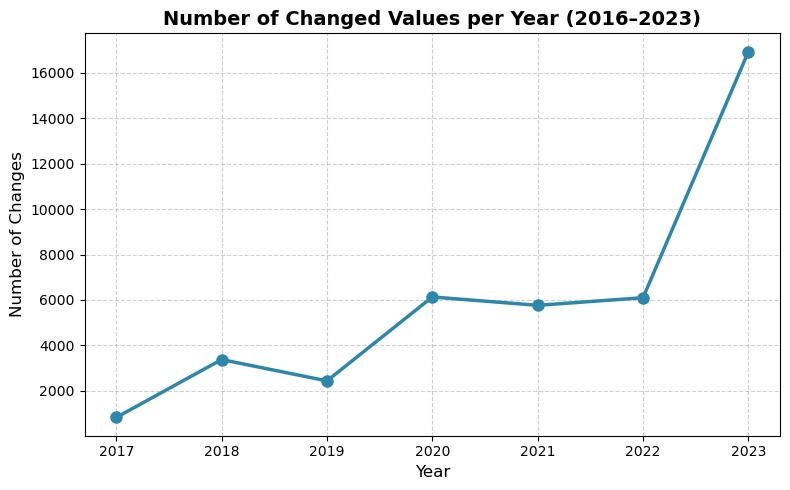

In [23]:
import matplotlib.pyplot as plt
import pandas as pd


# Count number of changes per year
counts = pd.Series(change_year.flatten()).value_counts()

# Restrict to range 2016–2023 and drop 2018 if missing
years = [y for y in range(2016, 2024) if y in counts.index]
values = [counts[y] for y in years]

# Create a nice-looking plot
plt.figure(figsize=(8, 5))
plt.plot(years, values, marker='o', linewidth=2.5, markersize=8, color='#2E86AB')

# Style it nicely
plt.title("Number of Changed Values per Year (2016–2023)", fontsize=14, fontweight='bold')
plt.xlabel("Year", fontsize=12)
plt.ylabel("Number of Changes", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(years)
plt.tight_layout()

plt.show()


In [47]:
def get_non_cloud_state(y,x,yr):
    pix_seq = stack[:, y, x]
    if yr == 0:
        return initial_state[y, x]
    else:
        current_pixel = stack[yr, y, x]
        if current_pixel < 1: # 0 (cloud) or -1 (no data)
            return get_non_cloud_state(y,x,yr-1)
        else:
            return current_pixel

In [49]:
with rasterio.open(path) as src:
    initial_state = src.read(1)
    final_state = src.read(2)
    change_year = src.read(3)
    
## Rebuild stack without any cloud
stack_no_cloud = stack.copy()
for yr in range(len(stack)):
    for y in range(H):
        for x in range(W):
            current_pixel = get_non_cloud_state(y,x,yr)
            stack_no_cloud[yr, y, x] = current_pixel

In [67]:
pd.Series(stack_no_cloud.flatten()).value_counts().sum()

11486160

In [85]:
(stack_no_cloud[:2] == 2).all(axis = 0)

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [129]:
cleared = []
revegetated = []
for yr in range(len(stack_no_cloud)):
    print('total cleared',(stack_no_cloud[yr] == 2).sum())
    cleared.append((stack_no_cloud[yr] == 2).sum())
#    if yr > 0:
#        print('newly cleared',((stack_no_cloud[yr] == 2) & (stack_no_cloud[yr-1] == 1)).sum())
#        print('newly revegetated',((stack_no_cloud[yr] == 1) & (stack_no_cloud[yr-1] == 2)).sum())
    print('revegetated',((stack_no_cloud[yr] == 1) & (initial_state == 2)).sum())
    revegetated.append(((stack_no_cloud[yr] == 1) & (initial_state == 2)).sum())


total cleared 17583
revegetated 0
total cleared 8639
revegetated 10511
total cleared 12709
revegetated 10429
total cleared 10262
revegetated 12511
total cleared 22552
revegetated 10823
total cleared 31159
revegetated 9552
total cleared 37214
revegetated 9432
total cleared 58911
revegetated 6237


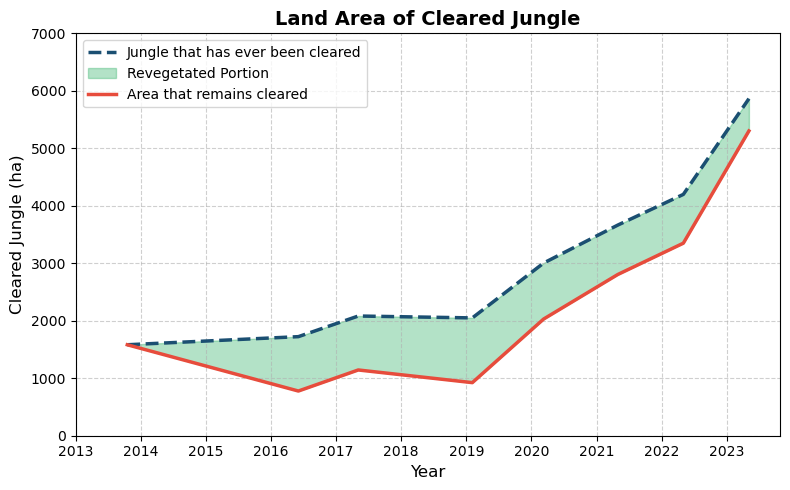

In [165]:
# convert to ha
np_cleared = np.array(cleared) * (30 * 30) / 10000 # 30*30 for m^2, then /10000 for ha
np_revegetated = np.array(revegetated) * (30 * 30) / 10000 # 30*30 for m^2, then /10000 for ha


# Restrict to range 2016–2023 and drop 2018 if missing
years = [date(y,1,1) for y in range(2013, 2024)]
dates = [date(2013,10,17),
            date(2016,6,3),
             date(2017,5,5),
             date(2019,2,4), 
             date(2020,3,10),
             date(2021,4,30),
             date(2022,5,3),
             date(2023,5,6)
        ]

# Create a nice-looking plot
plt.figure(figsize=(8, 5))
plt.plot(
    dates, np_cleared + np_revegetated,
    linestyle='--', linewidth=2.5, markersize=6,
    color='#1B4F72', label='Jungle that has ever been cleared'
)

plt.fill_between(
    dates, np_cleared, np_cleared + np_revegetated,
    color='#27AE60', alpha=0.35, label='Revegetated Portion'
)

plt.plot(
    dates, np_cleared,
    linestyle='-', linewidth=2.5, markersize=6,
    color='#E74C3C', label='Area that remains cleared'
)

#plt.plot(dates, np_revegetated, marker='o', linewidth=2.5, markersize=8, color='#2E86AB', label = 'Revegetated')


# Style it nicely
plt.title("Land Area of Cleared Jungle", fontsize=14, fontweight='bold')
plt.xlabel("Year", fontsize=12)
plt.ylabel("Cleared Jungle (ha)", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(years, labels = range(2013, 2024))
plt.ylim([0,7000])
plt.tight_layout()
plt.legend()

plt.show()


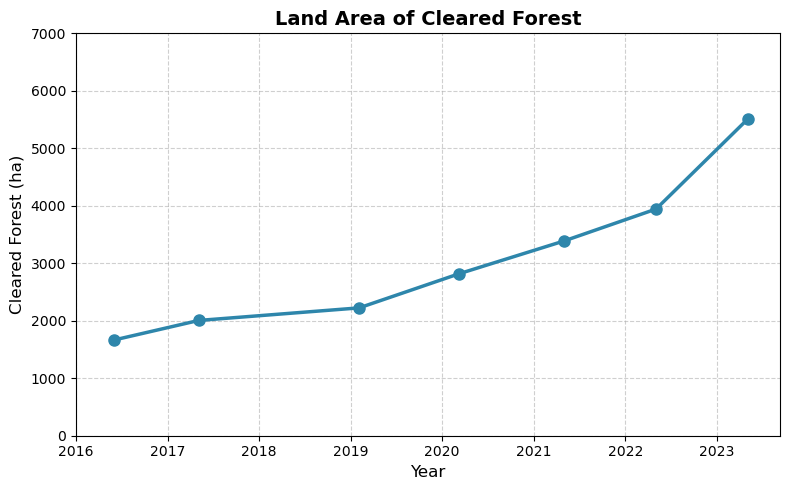

In [93]:
# CumSum of changes per year
counts = pd.Series(change_year.flatten()).value_counts().sort_index()[1:].cumsum()

# Add initial state count
counts = counts + (initial_state == 2).sum()

# convert to ha
counts = counts * (30 * 30) / 10000 # 30*30 for m^2, then /10000 for ha


# Restrict to range 2016–2023 and drop 2018 if missing
years = [date(y,1,1) for y in range(2016, 2024)]
dates = [date(2016,6,3),
             date(2017,5,5),
             date(2019,2,4), 
             date(2020,3,10),
             date(2021,4,30),
             date(2022,5,3),
             date(2023,5,6)
        ]
values = [counts[y] for y in range(2016, 2024) if y in counts.index]

# Create a nice-looking plot
plt.figure(figsize=(8, 5))
plt.plot(dates, values, marker='o', linewidth=2.5, markersize=8, color='#2E86AB')

# Style it nicely
plt.title("Land Area of Cleared Forest", fontsize=14, fontweight='bold')
plt.xlabel("Year", fontsize=12)
plt.ylabel("Cleared Forest (ha)", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(years, labels = range(2016, 2024))
plt.ylim([0,7000])
plt.tight_layout()

plt.show()


### Animated GIF

In [ ]:
classes = {
    3: ("Ocean", "#2878B5"),      # deep but natural blue
    0: ("Cloud", "#D9D9D9"),      # soft neutral grey
    1: ("Jungle", "#228B22"),     # rich green with good luminance
    2: ("Mining", "#E89C31"),     # warm amber/orange (less harsh)
    -1: ("No data", "#2878B5")    # very dark grey (less stark than black)
}


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
from matplotlib.colors import ListedColormap

# Extract and apply colormap
labels, colors = zip(*[(v[0], v[1]) for v in classes.values()])
values = list(classes.keys())

cmap = ListedColormap(colors)
norm = plt.Normalize(vmin=min(values), vmax=max(values))


fig, ax = plt.subplots()
ax.axis('off')


years = [2013, 2016, 2017, 2019, 2020, 2021, 2022, 2023]

def update(frame):
    im = ax.imshow(stack[frame], cmap=cmap, norm=norm, animated=True)
    im.set_array(stack[frame])
    ax.set_title(f"{years[frame]}")
    return [im]

ani = animation.FuncAnimation(
    fig, update, frames=len(stack),
    interval=15000,  # milliseconds per frame
    blit=True, repeat=False
)

# Save as GIF
ani.save("stack_animation_v2.gif", writer='pillow', fps=0.6)
plt.close()
print("✅ Saved as stack_animation_v2.gif")


In [ ]:
pd.Series(change_year.flatten()).count()* (30 * 30) / 1000000 